# Analysing Music Market Using SQL 

## Introduction 

In this project, I'll be working with Chinook database in order to answer some business questions in the music market using SQL. Chinook is a sample database and the Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers, like a small iTunes Store. 

Here are some facts about the Chinook data model:
- Media related data were created using real data from an iTunes Library. 
- Customer and employee information was manually created using fictitious names, addresses that can be located on Google maps, and other well formatted data (phone, fax, email, etc.).
- Sales information is auto generated using random data for a four year period.

The whole information is contained in eleven tables. Here is a diagram for the database, which will help us to understand the structure of the data: 


<img src="chinook.jpg">


Let's start by importing the necessary libraries and modules.

In [209]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Creating helper functions 

I will begin analysing the data, but before I would like to create some helper functions in python to save time in repeated actions. 


In [210]:
db = 'chinook.db'

# Create a function that takes a SQL query as an argument and returns a pandas dataframe of that query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
        
# Create a function that calls the run_query() function to return a list of all tables and views in the database
def show_tables():
    q = '''
    SELECT 
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table','view');
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## EXPLORING DATA  
## Analysing the most sold Genres in USA 

According to my imaginary scenario for this project, the record store made a deal with a record label and my responsibility is to select 3 albums from a list of 4, to be added to the store. All of these are brand new artists to us, means that they don't have their tracks on our database yet. Here are the artist names and the genre of music they make:

|Artist Name     | Genre |
|----------------|-------|
|Regal	         |Hip-Hop|
|Red Tone	     | Punk  |
|Meteor and the Girls|Pop|
|Slim Jim Bites  | Blues |

For this project we are going to focus on the USA market, and find out which genres have the best potential to make profit, so that we can choose the three artists accordingly. 

In order to complete this task, we are going to start by analysing which genres sell the best in the USA. 

I'll write a query to discover the best sold genres in the USA, and create a visualization using pandas. 


In [211]:
genres_USA = '''
WITH 
    usa_tracks_sales AS
    (
     SELECT 
         il.invoice_line_id,
         il.track_id
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     WHERE i.billing_country = 'USA'
    )
SELECT 
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) FROM usa_tracks_sales
        ) percentage 
FROM genre g
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN usa_tracks_sales uts ON uts.track_id = t.track_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
run_query(genres_USA)

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


I will plot this information to a bar plot to see the picture easily:

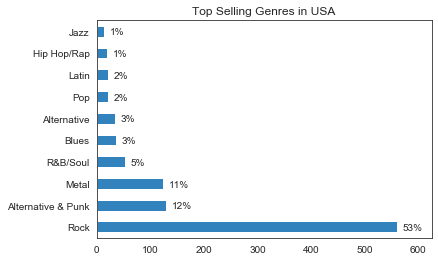

In [212]:
# save results in a variable for plotting
genre_sales_usa = run_query(genres_USA)

# setting index for the table and dropping the column selected as index
genre_sales_usa.set_index('genre', inplace=True, drop=True)

genre_sales_usa['tracks_sold'].plot.barh(
     title = 'Top Selling Genres in USA',
     xlim = (0, 625),
     colormap = plt.cm.tab20c
    )
plt.ylabel('')

for i,label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label,'tracks_sold']
    label = (genre_sales_usa.loc[label, 'percentage']*100).astype(int).astype(str) + '%'
    plt.annotate(str(label),(score + 10, i - 0.15))


Based on these results, we can easily see that the most sold genre in the USA is ROCK with over 50%, followed by Alternative & Punk by 12% and Metal 11%. 

In this case we are going to choose the artist who makes the most popular music in the USA, which are Punk, Blues and Pop music. The music genre that we are going to exclude is Hip Hop because it has only a 1% share in the whole US music market. 

The artist we choose after analysing our date are:
- Red Tone (Punk) 12%
- Slim Jim Bites (Blues) 3% 
- Meteor and the Girls (Pop) 2%

Even though we have chosen these artists, we can see that these are not very strong genres in the USA music market. Focusing on rock music would be a smarter idea, if our main concern is the sales. We can suggest to concentrate finding and adding some new rock artists in our store.


## Analysing Employee Sales Performances

As a next step I am going analyse the performance of the sales support agents. According to the database some agents performing better than others and my aim is to figure out its reasons. As the main criteria of employee performance, I am going to use the total dollar sales amount and I am going to use the whole invoice table this time instead of using only USA. 

Firstly, let's get familiar with the data and understand what kind of information we have in the database:

In [213]:
employee_table = '''
SELECT * FROM employee;
'''
run_query(employee_table)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com
5,6,Mitchell,Michael,IT Manager,1.0,1973-07-01 00:00:00,2016-10-17 00:00:00,5827 Bowness Road NW,Calgary,AB,Canada,T3B 0C5,+1 (403) 246-9887,+1 (403) 246-9899,michael@chinookcorp.com
6,7,King,Robert,IT Staff,6.0,1970-05-29 00:00:00,2017-01-02 00:00:00,590 Columbia Boulevard West,Lethbridge,AB,Canada,T1K 5N8,+1 (403) 456-9986,+1 (403) 456-8485,robert@chinookcorp.com
7,8,Callahan,Laura,IT Staff,6.0,1968-01-09 00:00:00,2017-03-04 00:00:00,923 7 ST NW,Lethbridge,AB,Canada,T1H 1Y8,+1 (403) 467-3351,+1 (403) 467-8772,laura@chinookcorp.com


We can see that there are only 3 Sales Support Agents. 

I will need to write a query that finds the total dollar amount of sales assigned to each sales support agent within the company to understand the picture better. 

In [214]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT 
          c.customer_id,
          c.support_rep_id, 
          SUM(i.total) total
     FROM customer c 
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT 
     e.first_name || " " || e.last_name employee_name,
     e.hire_date,
     SUM(csrs.total) total_sales,
     e.birthdate
FROM employee e
INNER JOIN customer_support_rep_sales csrs ON csrs.support_rep_id = e.employee_id
WHERE e.title = 'Sales Support Agent'
GROUP BY 1
ORDER BY 3 DESC;
'''

run_query(employee_sales_performance)

,employee_name,hire_date,total_sales,birthdate
0,Jane Peacock,2017-04-01 00:00:00,1731.51,1973-08-29 00:00:00
1,Margaret Park,2017-05-03 00:00:00,1584.00,1947-09-19 00:00:00
2,Steve Johnson,2017-10-17 00:00:00,1393.92,1965-03-03 00:00:00


Let's plot these results to make them more readable: 

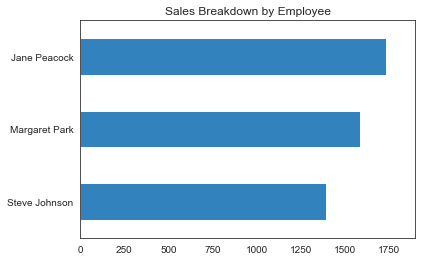

In [215]:
employee_sales = run_query(employee_sales_performance)
employee_sales.set_index('employee_name', inplace = True, drop = True)

employee_sales.sort_values('total_sales', inplace = True)
employee_sales['total_sales'].plot.barh(
                title = 'Sales Breakdown by Employee',
                legend = False,
                xlim = (0, 1900),
                colormap = plt.cm.tab20c
                )
plt.ylabel('')
plt.show()


At first there seems to be a big difference between the employee total sales. But, we need to check out the hire date in order to understand the picture better. 

Jane entered exactly one month before Margaret and Steve started 5 months after Margaret. So we can say that the difference between Margaret and Jane was supposed to be much smaller than the difference between Steve and Margaret (5 times to be exact). At this point we can also guess that the age of the employees plays a role in the sales. But before making any prejudiced decisions, it would be wise to conduct a performance review in order to get a clearer picture about the employee performances. 

## Analysing Sales by Country

My next mission in this project is to collect some information based on the country. The questions that I need to answer are:

- Total number of customers
- Total value of sales
- Average value of sales per customer
- Average order value

In the dataset some countries have just one customer, I will group these countries as "Other".

Let's start by calculating the total number of customers by country:


In [216]:
# analyzing sales by country
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
         CASE
             WHEN
                 (SELECT COUNT(*)
                  FROM customer
                  WHERE country = c.country
                 ) = 1 THEN 'Other'
             ELSE c.country
         END AS country,
         c.customer_id,
         il.*
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    )

SELECT 
    country,
    total_num_customers,
    total_sales_value,
    avg_sales_customer,
    avg_order_value
FROM
    (
     SELECT
         country,
         COUNT(DISTINCT (customer_id)) total_num_customers,
         TOTAL(unit_price) total_sales_value,
         TOTAL(unit_price) / COUNT(DISTINCT (customer_id)) avg_sales_customer,
         TOTAL(unit_price) / COUNT(DISTINCT (invoice_id)) avg_order_value,
         CASE
             WHEN country = "Other" THEN 1
             ELSE 0
         END AS sort
     FROM country_or_other
     GROUP BY country
     ORDER BY sort, total_sales_value DESC 
    );
'''
run_query(sales_by_country)

,country,total_num_customers,total_sales_value,avg_sales_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


Let's visualise these results, plotting will help to read the information better. 

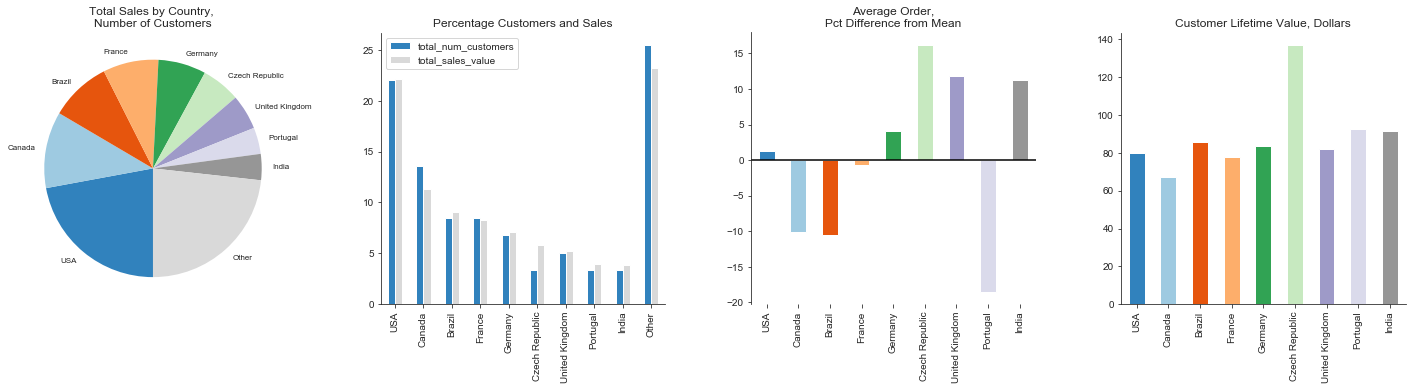

In [217]:
country_sales_df = run_query(sales_by_country)

# set index and dropping column that is selected as index
country_sales_df.set_index('country', inplace=True, drop=True)

# set colormap 
colors = [plt.cm.tab20c(i) for i in np.linspace(0, 1, country_sales_df.shape[0])]

# instantiate a figure object and creating subplots/axes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25,5))

# unpack the axes/subplots for customized editing/plotting
ax1, ax2, ax3, ax4 = axes.flatten()

# adjust the height and width of subplots
fig.subplots_adjust(hspace=.5, wspace=.3)

# 1. total sales by country - (1,1)
sales_plot = country_sales_df['total_sales_value'].copy().rename('')
sales_plot.plot.pie(ax=ax1, colormap=plt.cm.tab20c,
                    title='Total Sales by Country, \nNumber of Customers', 
                    startangle=-90, counterclock=False, 
                    fontsize=8, wedgeprops={'linewidth':0}
                   )


# 2. percentage customers and sales - (1,2)
cols = ['total_num_customers', 'total_sales_value']
customers_and_sales = country_sales_df[cols].copy()
customers_and_sales.index.name = ''
for c in cols:
    customers_and_sales[c] /= customers_and_sales[c].sum() / 100
customers_and_sales.plot.bar(ax=ax2, colormap=plt.cm.tab20c,
                            title='Percentage Customers and Sales'
                           )
ax2.tick_params(top='off', right='off', left='off', bottom='off')
# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')


# 3. average order - (2,1)
avg_order = country_sales_df['avg_order_value'].copy()
avg_order.index.name = ''
mean_diff_from_avg = avg_order * 100 / avg_order.mean() - 100
# dropping 'Other' group as it's not required here
mean_diff_from_avg.drop('Other', inplace=True)
mean_diff_from_avg.plot.bar(ax=ax3, color=colors,
                            title='Average Order,\nPct Difference from Mean'
                           )
ax3.tick_params(top='off', right='off', left='off', bottom='off')
ax3.axhline(0, color='k')
# Hide the right,top and bottom spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
# Only show ticks on the left and bottom spines
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')


# 4. customer liftime value - (2,2)
avg_customer_sales = country_sales_df['avg_sales_customer'].copy()
avg_customer_sales.index.name = ''
# dropping 'Other' group as it's not required here
avg_customer_sales.drop('Other',inplace=True)
avg_customer_sales.plot.bar(ax=ax4, color=colors, 
                            title='Customer Lifetime Value, Dollars'
                           )
ax4.tick_params(top='off', right='off', left='off', bottom='off')
# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')

plt.show()

Let's examine the plots to understand the sales better. From the first pie chart we can see that USA has the highest value of Total Sales by Country. It is followed by Canada, Brazil and France. 

In the second plot we have the bar plot which shows the percentage customers and sales. From this plot we can easily see that the countries with the highest total sales values has a high number of customers, hence the highest total value. Here we can notice that the Czech Republic has a significantly higher total value compared with its total customer number. This might be a hint to understand the best countries to invest.

In the third plot we investigate thee average order, difference from the mean. This will give us an idea about the countries which are worth to invest our money for advertising. As we guessed from the previous plot Czech Republic has the highest value and it is followed by United Kingdom, India and Germany. 

We can double check this discovery on our last plot, which shows the customer lifetime value in dollars. 

We can conclude that there may be an opportunity to invest in the following countries:

- Czech Republic
- United Kingdom
- India
- Germany

On the other hand, the amount of data from each of these countries is relatively low and therefore, it would be wise to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers until we get a reliable sample size.

Next, I'll analyse which is a better investment, buying full albums or single songs. 

## Albums vs Individual Tracks


As the last analysis I am going to figure out the profitability difference between albums and individual tracks. In Chinook, customers can buy both individual tracks and whole albums. However, the cannot buy a whole album and then add individual tracks to the same purchase. We are going to investigate if this is a winning strategy or not. 

I will write a query to analyse:

- Number of invoices
- Percentage of the invoice for each case

In [218]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                       ) percent
FROM
    (
    SELECT
        ift.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                                     ) 
                 ) IS NULL
             THEN 'yes'
             ELSE 'no'
         END AS album_purchase
     FROM invoice_first_track ift
    )
GROUP BY 1;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


From the query above, we can see that 18.6% of the customers buy whole albums. Therefore, I'd still recommend to investing in the whole albums, because doing otherwise will mean to lose almost 20% of the profit. 

## Conclusion

In this project, I analyzed the Chinook database, a fictional digital music store, in order to answer some business questions to increase profits and reduce losses. The topics that I touched were:

- Choosing the right artist to invest based on the analysis in the USA market. 
- Analysing Employee Sales Performances for a higher productivity
- Analysing Sales by Country to choose in which market they should advertise
- More profitable investment: Albums or Individual Tracks

